In [1]:
%reload_ext autoreload
%autoreload 2

# from CATSegTrainer import get_cfg, add_deeplab_config, add_cat_seg_config, setup_logger, Trainer, DetectionCheckpointer

from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.checkpoint import DetectionCheckpointer
import time
from CustomDataset import ArenaDataset
from torch.utils.data import DataLoader
from utils import *
from torch import nn
import datetime
import torch
import json
from contextlib import ExitStack

torch.cuda.is_available()

True

In [4]:

# args = default_argument_parser().parse_args()
args = default_argument_parser()
# args.config_file = "main_configs/vitb_vlmaps.yaml"
args.config_file = "main_configs/vitl_vlmaps.yaml"
args.num_machines = 1
args.num_gpus = 1
args.machine_rank = 0
args.dist_url = None
args.eval_only = True
args.resume = False
args.opts = []

# print the values of the argparse object with indentation
print("Command Line Args:")
for arg in vars(args):
    print(f"    {arg}: {getattr(args, arg)}")


Command Line Args:
    description: None
    argument_default: None
    prefix_chars: -
    conflict_handler: error
    _registries: {'action': {None: <class 'argparse._StoreAction'>, 'store': <class 'argparse._StoreAction'>, 'store_const': <class 'argparse._StoreConstAction'>, 'store_true': <class 'argparse._StoreTrueAction'>, 'store_false': <class 'argparse._StoreFalseAction'>, 'append': <class 'argparse._AppendAction'>, 'append_const': <class 'argparse._AppendConstAction'>, 'count': <class 'argparse._CountAction'>, 'help': <class 'argparse._HelpAction'>, 'version': <class 'argparse._VersionAction'>, 'parsers': <class 'argparse._SubParsersAction'>, 'extend': <class 'argparse._ExtendAction'>}, 'type': {None: <function ArgumentParser.__init__.<locals>.identity at 0x7f71a995b9d0>}}
    _actions: [_HelpAction(option_strings=['-h', '--help'], dest='help', nargs=0, const=None, default='==SUPPRESS==', type=None, choices=None, help='show this help message and exit', metavar=None), _StoreActi

In [5]:

# launch is used to detect if the execution needs to be addressed to a single or multiple machines and gpus
# launch(
#     main,
#     args.num_gpus,
#     num_machines=args.num_machines,
#     machine_rank=args.machine_rank,
#     dist_url=args.dist_url,
#     args=(args,),
# )

def trivial_batch_collator(batch):
    """
    A batch collator that does nothing.
    """
    return batch

cfg = setup(args)
# torch.set_float32_matmul_precision("high")
print(cfg.OUTPUT_DIR)
if args.eval_only:
    output_list = []
    features_list = []
    time_list = []
    model = Trainer.build_model(cfg)
    DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
        cfg.MODEL.WEIGHTS, resume=args.resume
    )
    # read the list contained in the json file in cfg.DATASETS.TEST and define the labels
    labels = json.load(open(cfg.MODEL.SEM_SEG_HEAD.TEST_CLASS_JSON))
    print(labels)
    model.sem_seg_head.predictor.define_labels(labels)
    ds = ArenaDataset(cfg.DATASETS.TEST[0])
    # res = Trainer.test_ds(cfg, model, ds)
    data_loader = DataLoader(ds, batch_size=1, num_workers=cfg.DATALOADER.NUM_WORKERS, collate_fn=trivial_batch_collator)
    total = len(data_loader)

    num_warmup = min(5, total - 1)
    start_time = time.perf_counter()
    total_data_time = 0
    total_compute_time = 0
    total_eval_time = 0
    with ExitStack() as stack:
        if isinstance(model, nn.Module):
            stack.enter_context(inference_context(model))
        stack.enter_context(torch.no_grad())

        start_data_time = time.perf_counter()
        for idx, inputs in enumerate(data_loader):

            start_compute_time = time.perf_counter()
            print(inputs[0]['image'].shape)
            outputs, img_features = model(inputs)
            output_list.append(outputs)
            features_list.append(img_features)
            time_list.append(time.perf_counter() - start_compute_time)
            break
            
        end_data_time = time.perf_counter()
        print(f"Total time: {end_data_time - start_time}")

else:
    trainer = Trainer(cfg)
    trainer.resume_or_load(resume=args.resume)

WARNING [09/03 16:34:05 fvcore.common.config]: Loading config main_configs/vitl_vlmaps.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
[09/03 16:34:05 detectron2]: Rank of current process: 0. World size: 1
[09/03 16:34:06 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.19 (default, Mar 20 2024, 19:58:24) [GCC 11.2.0]
numpy                   1.24.4
detectron2              0.6 @/home/r1-user/miniconda3/envs/ovseg/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.3
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.1 @/home/r1-user/miniconda3/envs/ovseg/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                

/home/r1-user/miniconda3/envs/ovseg/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


torch.Size([22, 32, 96, 96])
torch.Size([22, 1, 96, 96])
torch.Size([1, 22, 96, 96])
Total time: 1.4233548890333623


In [6]:
outputs[0]['sem_seg'][:, 0, 0]

tensor([6.7243e-04, 1.5448e-03, 1.4016e-01, 5.5583e-03, 2.7965e-04, 6.1653e-01,
        4.6729e-03, 1.0792e-02, 1.0472e-03, 9.1820e-02, 5.2058e-03, 3.9464e-04,
        1.1796e-04, 8.0238e-05, 5.5497e-05, 1.9622e-03, 7.9656e-04, 1.5612e-03,
        1.0472e-03, 1.2377e-02, 6.6966e-03, 2.3570e-04], device='cuda:0')

In [7]:
outputs[0]['sem_seg'].shape

torch.Size([22, 480, 640])

In [8]:
ds[0]['image'].shape

torch.Size([3, 480, 640])

In [9]:
img_features.shape

torch.Size([1, 576, 768])

In [10]:
# from einops import rearrange

# res3 = rearrange(image_features, "B (H W) C -> B C H W", H=24)
# res4 = rearrange(self.layers[0][1:, :, :], "(H W) B C -> B C H W", H=24)
# res5 = rearrange(self.layers[1][1:, :, :], "(H W) B C -> B C H W", H=24)

# clip_pretrained = "ViT-L/14@336px"

# proj_dim = 768 if clip_pretrained == "ViT-B/16" else 1024

# upsample1 = nn.ConvTranspose2d(proj_dim, 256, kernel_size=2, stride=2)
# upsample2 = nn.ConvTranspose2d(proj_dim, 128, kernel_size=4, stride=4)

# res4 = upsample1(res4)
# res5 = upsample2(res5)

# feature_resolution = [24, 24]

# features = {'res5': res5, 'res4': res4, 'res3': res3,}

# img_feat = rearrange(features[:, 1:, :], "b (h w) c->b c h w", h=feature_resolution[0], w=feature_resolution[1])


# vis = [vis_guidance[k] for k in vis_guidance.keys()][::-1]
#         text = self.class_texts if self.training else self.test_class_texts
#         text = [text[c] for c in gt_cls] if gt_cls is not None else text
#         text = self.get_text_embeds(text, self.prompt_templates, self.clip_model, prompt)
        
#         text = text.repeat(x.shape[0], 1, 1, 1)
# img_feats = F.normalize(img_feats, dim=1) # B C H W

In [11]:
labels = model.sem_seg_head.predictor.test_class_texts

/tmp/ipykernel_2084740/1142116301.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}


['chair', 'ceiling', 'robot', 'table', 'wall', 'floor', 'computer', 'tv', 'display', 'desk']


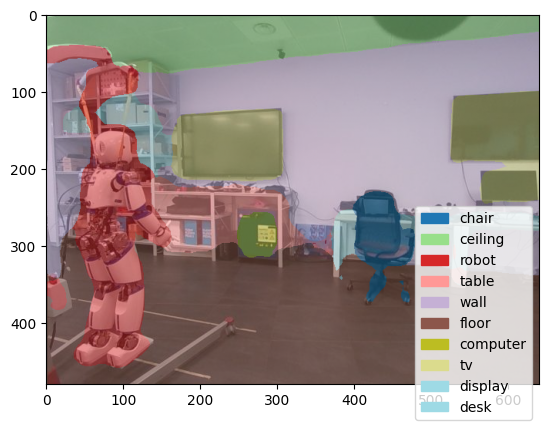

In [12]:
# visualize the output as a segmentation mask

import matplotlib.pyplot as plt
import numpy as np
import cv2

index = 0

sample = ds[index]

image = sample['image'].permute(1, 2, 0).numpy()

label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}

outputs = output_list[index]
mask = outputs[0]['sem_seg'].cpu().numpy()
mask = np.argmax(mask, axis=0)
# rearrange the mask to match the original image shape
# mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# iterate over the mask pixels and assign the color to the corresponding label
mask_color = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float64)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask_color[i, j] = label_index_to_color_dict[mask[i, j]]

mask_color[0][0]

detected = [labels[i] for i in np.unique(mask)]
print(detected)

plt.imshow(image)
plt.imshow(mask_color, alpha=0.5)

# set the legend outside the plot
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=label_index_to_color_dict[i], label=labels[i]) for i in np.unique(mask)], loc='upper left', bbox_to_anchor=(1, 1))

assert image.shape[:2] == mask.shape == mask_color.shape[:2], (image.shape[:2], mask.shape, mask_color.shape[:2])

plt.show()


In [9]:
# visualize the output as a segmentation mask

import matplotlib.pyplot as plt
import numpy as np
import cv2

index = 0

sample = ds[index]

image = sample['image'].permute(1, 2, 0).numpy()

label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}

outputs = output_list[index]
mask = outputs[0]['downscaled_sem_seg'].cpu().numpy()
mask = np.argmax(mask, axis=0)
# rearrange the mask to match the original image shape
# mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# iterate over the mask pixels and assign the color to the corresponding label
mask_color = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float64)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask_color[i, j] = label_index_to_color_dict[mask[i, j]]

mask_color[0][0]

detected = [labels[i] for i in np.unique(mask)]
print(detected)

plt.imshow(image)
plt.imshow(mask_color, alpha=0.5)
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=label_index_to_color_dict[i], label=labels[i]) for i in np.unique(mask)])

assert image.shape[:2] == mask.shape == mask_color.shape[:2], (image.shape[:2], mask.shape, mask_color.shape[:2])

plt.show()


/tmp/ipykernel_287430/2981576529.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  label_index_to_color_dict = {i : plt.cm.get_cmap('tab20')(i) for i in range(len(labels))}


IndexError: tuple index out of range